In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import scipy.stats as stats

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

import shapely.geometry as sg
from shapely.geometry import Point

import sys
sys.path.append(os.path.abspath(".."))
from function import DOWN_raw
from function import ART_preprocessing as ART_pre

import warnings
warnings.filterwarnings('ignore')

## Export Relative Errors for each region as csv
# Using Dario-QC data

In [2]:
# font = 'SAT'
font = 'DOWN'

In [3]:
QC_method = 'QCv1_Flag1'
# QC_method = 'QCv1_Flag_Rec'

In [4]:
lon_min, lon_max, lat_min, lat_max, area, toll = 6.5, 19, 36.5, 48, 'ITALY', 0.002

Tr = [5, 10, 20, 50, 100]
Fi = 1 - 1/np.array(Tr)

In [5]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [6]:
obs_base = os.path.join('/','media','arturo','T9','Data','Italy', 'stations', 'Italy_raingauges')
sat_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_DOWN')

In [7]:
METADATA = pd.read_csv(os.path.join(obs_base, 'QC', 'METADATA', 'METADATA_INTENSE_UPDATE.csv'))
METADATA.head(2)

,File,ISO,Region,Code,Name,Elevatn,Or_EPSG,CRS_E,CRS_N,Lat,Lon,Yr_Strt,Yer_End,INTENSE,AGENCY,Source,TimeZon
0,IT-210_PIE-001030-900_0060_QCv1.csv,IT-210,Piedmont,PIE-001030-900,BORGOFRANCODIVREA,337.0,32632,410005.0,5040731.0,45.514302,7.847798,1988-05-08 05:00:00,2024-09-09 01:00:00,DT,ARPA Piemonte,Piedmont,UTC
1,IT-210_PIE-001097-900_0060_QCv1.csv,IT-210,Piedmont,PIE-001097-900,CUMIANA,327.0,32632,373092.0,4980177.0,44.963696,7.390821,1988-01-29 03:00:00,2024-09-18 12:00:00,DT,ARPA Piemonte,Piedmont,UTC


## Load ISO regions and names

In [8]:
ISO_names = pd.read_csv(os.path.join(obs_base,'ISO_IT_REGION_EN_QC.csv'))
ISO_names.head(2)

,Region,ISO
0,Alto-Adige,IT-322
1,Aosta Valley,IT-230


## Load ENSEMBLE data

In [9]:
dir_in = os.path.join(sat_base,'ITALY_ENSEMBLE_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc')
data = xr.open_dataset(dir_in)

lat_sat = data.lat.values
lon_sat = data.lon.values
lon2d_sat, lat2d_sat = np.meshgrid(lon_sat, lat_sat)

Sat_year = data.year.values

print(f'Load {font} parameters')
if font == 'SAT':
    Sat_NYd = data.NYs.values
    Sat_CYd = data.CYs.values
    Sat_WYd = data.WYs.values
elif font == 'DOWN':
    Sat_NYd = data.NYd.values
    Sat_CYd = data.CYd.values
    Sat_WYd = data.WYd.values
else:
    print('Font dont found')
    sys.exit()

Load DOWN parameters


## Choose the Region

In [10]:
Tr_index = 3
print(f'Tr: {Tr[Tr_index]} years')

Tr: 50 years


In [11]:
dir_read = os.path.join(obs_base, 'QC', 'data_1h')
regions_ISO = [d for d in os.listdir(dir_read) if os.path.isdir(os.path.join(dir_read, d))]

In [12]:
diccionario_OBS_WN = {}
diccionario_OBS_WC = {}
diccionario_OBS_WW = {}

diccionario_SAT_WN = {}
diccionario_SAT_WC = {}
diccionario_SAT_WW = {}

diccionario_RE = {}
diccionario_LAT = {}
diccionario_LON = {}

for rr in range(len(regions_ISO)):#len(ISO_names)
    region_ISO = regions_ISO[rr]
    region_label = ISO_names[ISO_names['ISO']==region_ISO]

    print(f'{rr+1}: {region_label['Region'].values[0]} ({region_ISO})')

    METADATA_clear = METADATA[METADATA['ISO']==region_ISO].reset_index(inplace=False)

    SAT_WN, SAT_WC, SAT_WW = [], [], []
    OBS_WN, OBS_WC, OBS_WW = [], [], []
    LAT, LON, RE_50 = [], [], []
    for nn in range(len(METADATA_clear)):#len(METADATA_clear)
        filename = f'{METADATA_clear['File'].values[nn]}'
        lat_obs = METADATA_clear['Lat'][nn]
        lon_obs = METADATA_clear['Lon'][nn]

        OBS_pd = pd.read_csv(os.path.join(obs_base, 'QC', 'DATA_1dy', 'statistics', QC_method, region_ISO, filename))
        OBS_pd = OBS_pd[(OBS_pd['Year']>=2002)&(OBS_pd['Year']<=2023)].reset_index(drop=True)
        if len(OBS_pd) == 0:
            continue
        
        else:
            OBS_N = OBS_pd['N'].values
            OBS_C = OBS_pd['C'].values
            OBS_W = OBS_pd['W'].values
            OBS_Y = OBS_pd['Year'].values

            mask = ~np.isnan(OBS_N)

            OBS_N = OBS_N[mask]
            OBS_C = OBS_C[mask]
            OBS_W = OBS_W[mask]
            OBS_Y = OBS_Y[mask]

            if len(OBS_Y) >= 16: # greather than 8 years

                x0 = np.nanmean(OBS_C)
                OBS_Q, flag = DOWN_raw.mev_quant_update(Fi, x0, OBS_N, OBS_C, OBS_W, thresh=1)
                OBS_Q2 = np.where(flag, OBS_Q, np.nan)

                distances = ART_pre.haversine(lat2d_sat, lon2d_sat, lat_obs, lon_obs)
                min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
                Sat_NYd_ = Sat_NYd[:,min_index[0],min_index[1]]
                Sat_CYd_ = Sat_CYd[:,min_index[0],min_index[1]]
                Sat_WYd_ = Sat_WYd[:,min_index[0],min_index[1]]

                Sat_pd = pd.DataFrame({'Year':Sat_year, 'N':Sat_NYd_, 'C':Sat_CYd_, 'W':Sat_WYd_})
                # Sat_pd_filtered = Sat_pd[Sat_pd['Year'].isin(OBS_pd['Year'])].reset_index()
                Sat_pd_filtered = Sat_pd.set_index('Year').loc[OBS_pd['Year']].reset_index()

                SAT_N = Sat_pd_filtered['N'].values
                SAT_C = Sat_pd_filtered['C'].values
                SAT_W = Sat_pd_filtered['W'].values
                SAT_Y = Sat_pd_filtered['Year'].values

                SAT_N = SAT_N[mask]
                SAT_C = SAT_C[mask]
                SAT_W = SAT_W[mask]
                SAT_Y = SAT_Y[mask]

                if len(OBS_Y) != len(SAT_Y):
                    print('ERROR')
                    sys.exit()
                else:
                    
                    OBS_WN.extend(OBS_N)
                    OBS_WC.extend(OBS_C)
                    OBS_WW.extend(OBS_W)
                    
                    SAT_WN.extend(SAT_N)
                    SAT_WC.extend(SAT_C)
                    SAT_WW.extend(SAT_W)
                    
                    x0 = np.nanmean(SAT_C)
                    SAT_Q, flag = DOWN_raw.mev_quant_update(Fi, x0, SAT_N, SAT_C, SAT_W, thresh=1)
                    SAT_Q2 = np.where(flag, SAT_Q, np.nan)

                relative_e_50 = (SAT_Q2[3] - OBS_Q2[3])/OBS_Q2[3]

                LAT.append(float(lat_obs))
                LON.append(float(lon_obs))
                RE_50.append(float(relative_e_50))

            else:        
                continue

            RE_50_M = np.array(RE_50)
            RE_50_M = RE_50_M[(RE_50_M>-1)&(RE_50_M<1)]
            diccionario_RE[region_ISO] = RE_50_M

            LAT_M = np.array(LAT)
            LAT_M = LAT_M[(np.array(RE_50)>-1)&(np.array(RE_50)<1)]
            diccionario_LAT[region_ISO] = LAT_M

            LON_M = np.array(LON)
            LON_M = LON_M[(np.array(RE_50)>-1)&(np.array(RE_50)<1)]
            diccionario_LON[region_ISO] = LON_M

            OBS_WN_N = np.array(OBS_WN)
            diccionario_OBS_WN[region_ISO] = OBS_WN_N
            
            OBS_WC_N = np.array(OBS_WC)
            diccionario_OBS_WC[region_ISO] = OBS_WC_N
            
            OBS_WW_N = np.array(OBS_WW)
            diccionario_OBS_WW[region_ISO] = OBS_WW_N

            SAT_WN_N = np.array(SAT_WN)
            diccionario_SAT_WN[region_ISO] = SAT_WN_N
            
            SAT_WC_N = np.array(SAT_WC)
            diccionario_SAT_WC[region_ISO] = SAT_WC_N
            
            SAT_WW_N = np.array(SAT_WW)
            diccionario_SAT_WW[region_ISO] = SAT_WW_N

1: Piedmont (IT-210)
2: Aosta Valley (IT-230)
3: Lombardy (IT-250)
4: Trentino (IT-321)
5: Alto-Adige (IT-322)
6: Veneto (IT-340)
7: Friuli-Venezia Giulia (IT-360)
8: Liguria (IT-420)
9: Emilia-Romagna (IT-450)
10: Tuscany (IT-520)
11: Umbria (IT-550)
12: Marche (IT-570)
13: Lazio (IT-620)
14: Molise (IT-670)
15: Campania (IT-720)
16: Apulia (IT-750)
17: Basilicata (IT-770)
18: Calabria (IT-780)
19: Sicily (IT-820)
20: Sardinia (IT-880)


## Export Weibull Parameters

In [13]:
diccionario_OBS_WN = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_OBS_WN.items()]))
diccionario_OBS_WC = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_OBS_WC.items()]))
diccionario_OBS_WW = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_OBS_WW.items()]))

## Remove W outlier value

In [14]:
diccionario_OBS_WW = diccionario_OBS_WW.mask(diccionario_OBS_WW > 10, np.nan)
diccionario_OBS_WC = diccionario_OBS_WC.mask(diccionario_OBS_WW > 10, np.nan)
diccionario_OBS_WN = diccionario_OBS_WN.mask(diccionario_OBS_WW > 10, np.nan)

Text(0.5, 0, 'Regions')

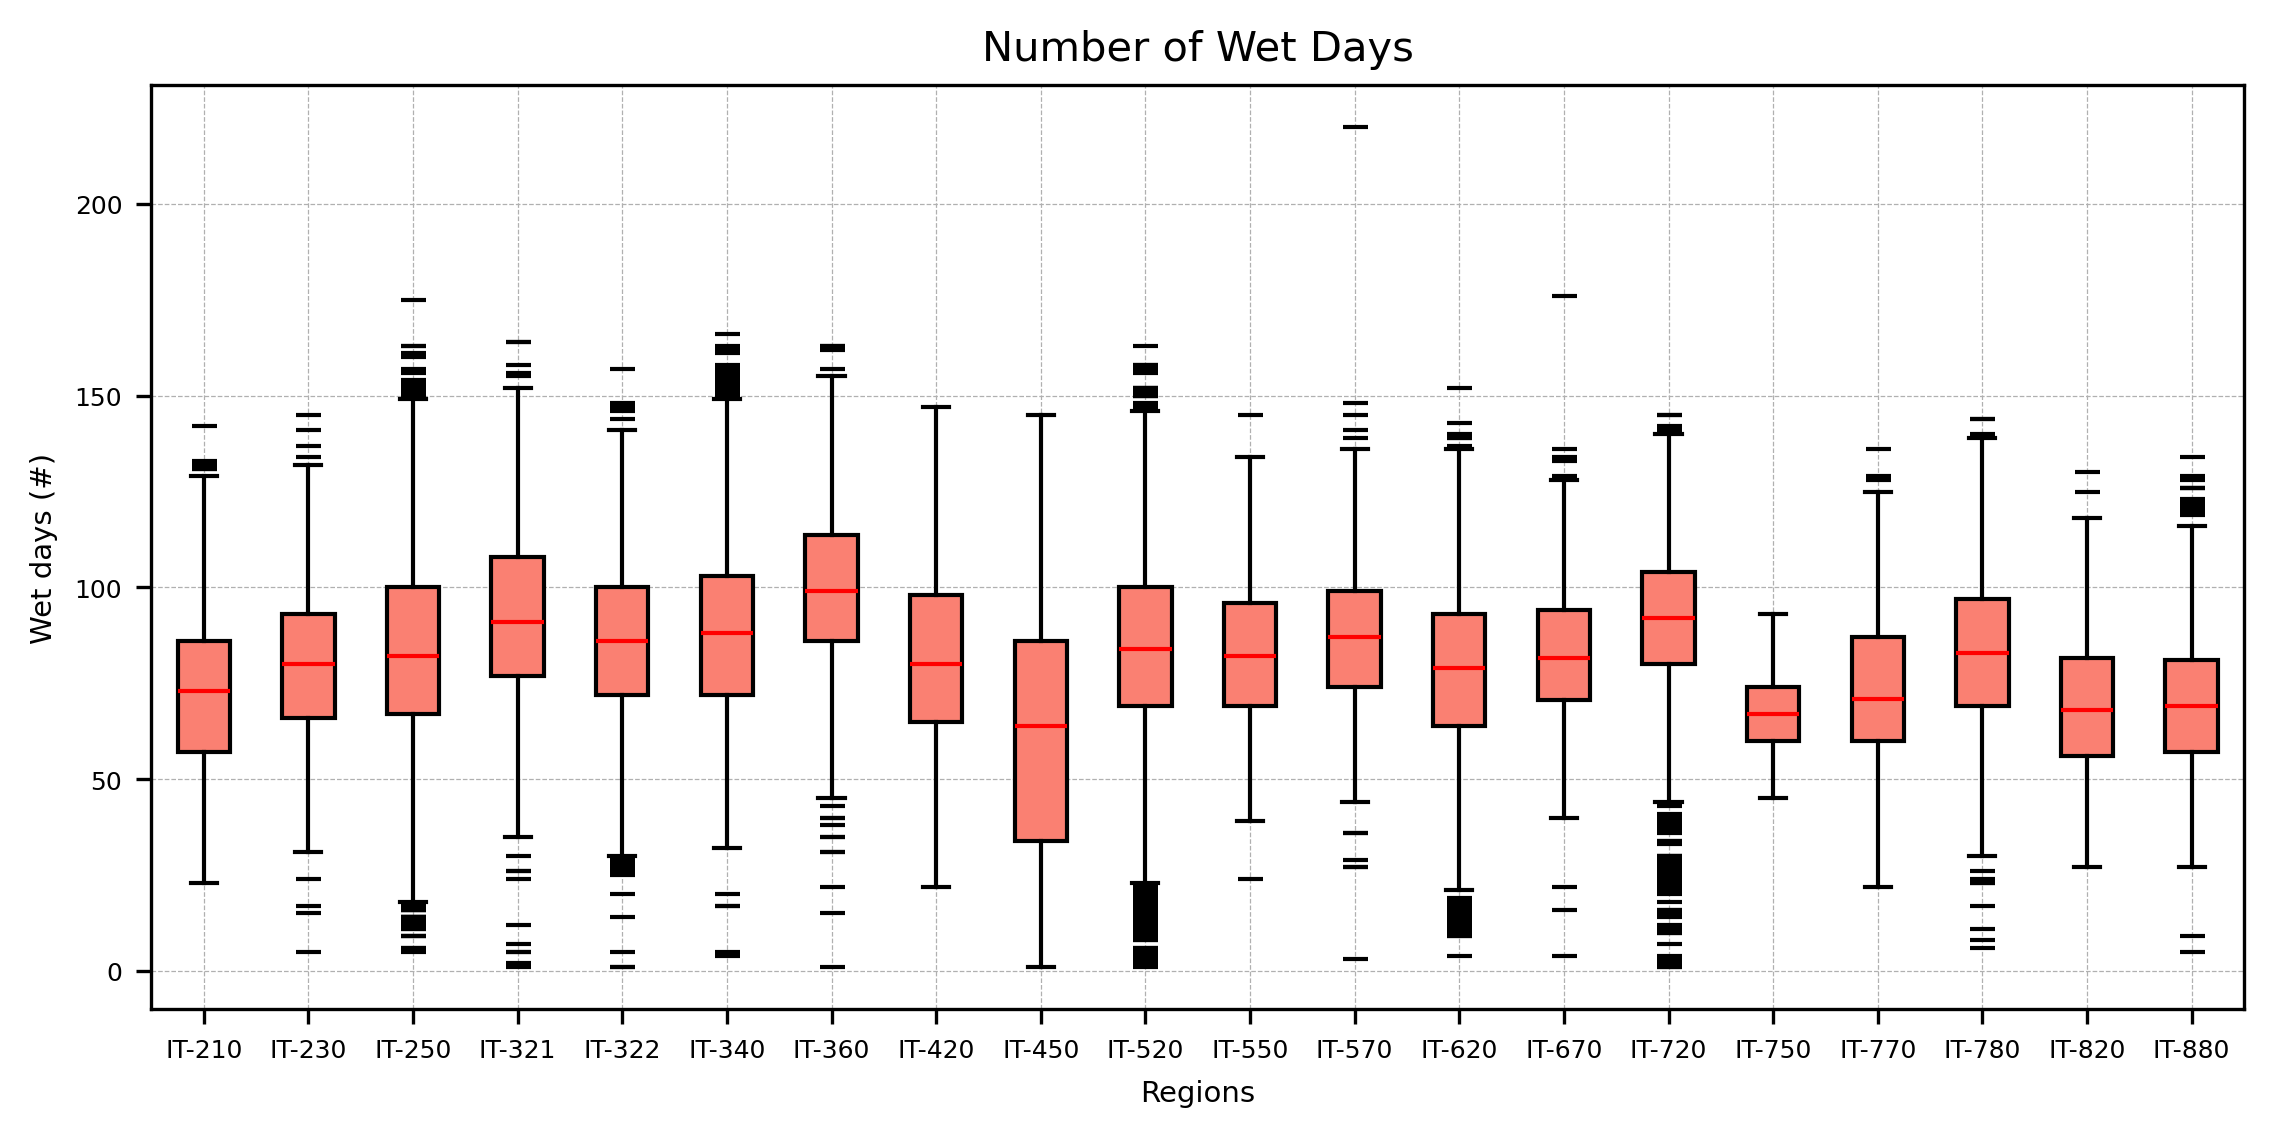

In [15]:
fig = plt.figure(figsize=(9,4),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])

SAT_boxprops = dict(facecolor='salmon')
DOWN_boxprops = dict(facecolor='royalblue')

meanprops=dict(linestyle='-',color="g",linewidth=1)
flierprops = dict(marker='_',markeredgecolor='k',linewidth=1.5)
medianprops = dict(linestyle='-', linewidth=1, color='r')

SAT_boxes = []
DOWN_boxes = []
medians = []
fliers = []
for pos in range(len(regions_ISO)):#len(regions_ISO)
    pre = diccionario_OBS_WN[regions_ISO[pos]].values
    pre_tmp = pre[~np.isnan(pre)]

    SAT_box = ax1.boxplot(pre_tmp,positions=[2*pos],
    widths=1,boxprops=SAT_boxprops,
    showmeans=False,meanline=True,meanprops=meanprops,
    medianprops=medianprops,
    showfliers=True,flierprops=flierprops,
    patch_artist=True,notch=False)

ax1.set_xlim(-1,39)

ax1.set_xticks(np.arange(0,40,2))
ax1.set_xticklabels(regions_ISO)

ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.grid(linewidth=0.3, linestyle='--')

ax1.set_title('Number of Wet Days', fontsize=10, loc='center')
ax1.set_ylabel('Wet days (#)', fontsize=7)
ax1.set_xlabel('Regions', fontsize=7)

Text(0.5, 0, 'Regions')

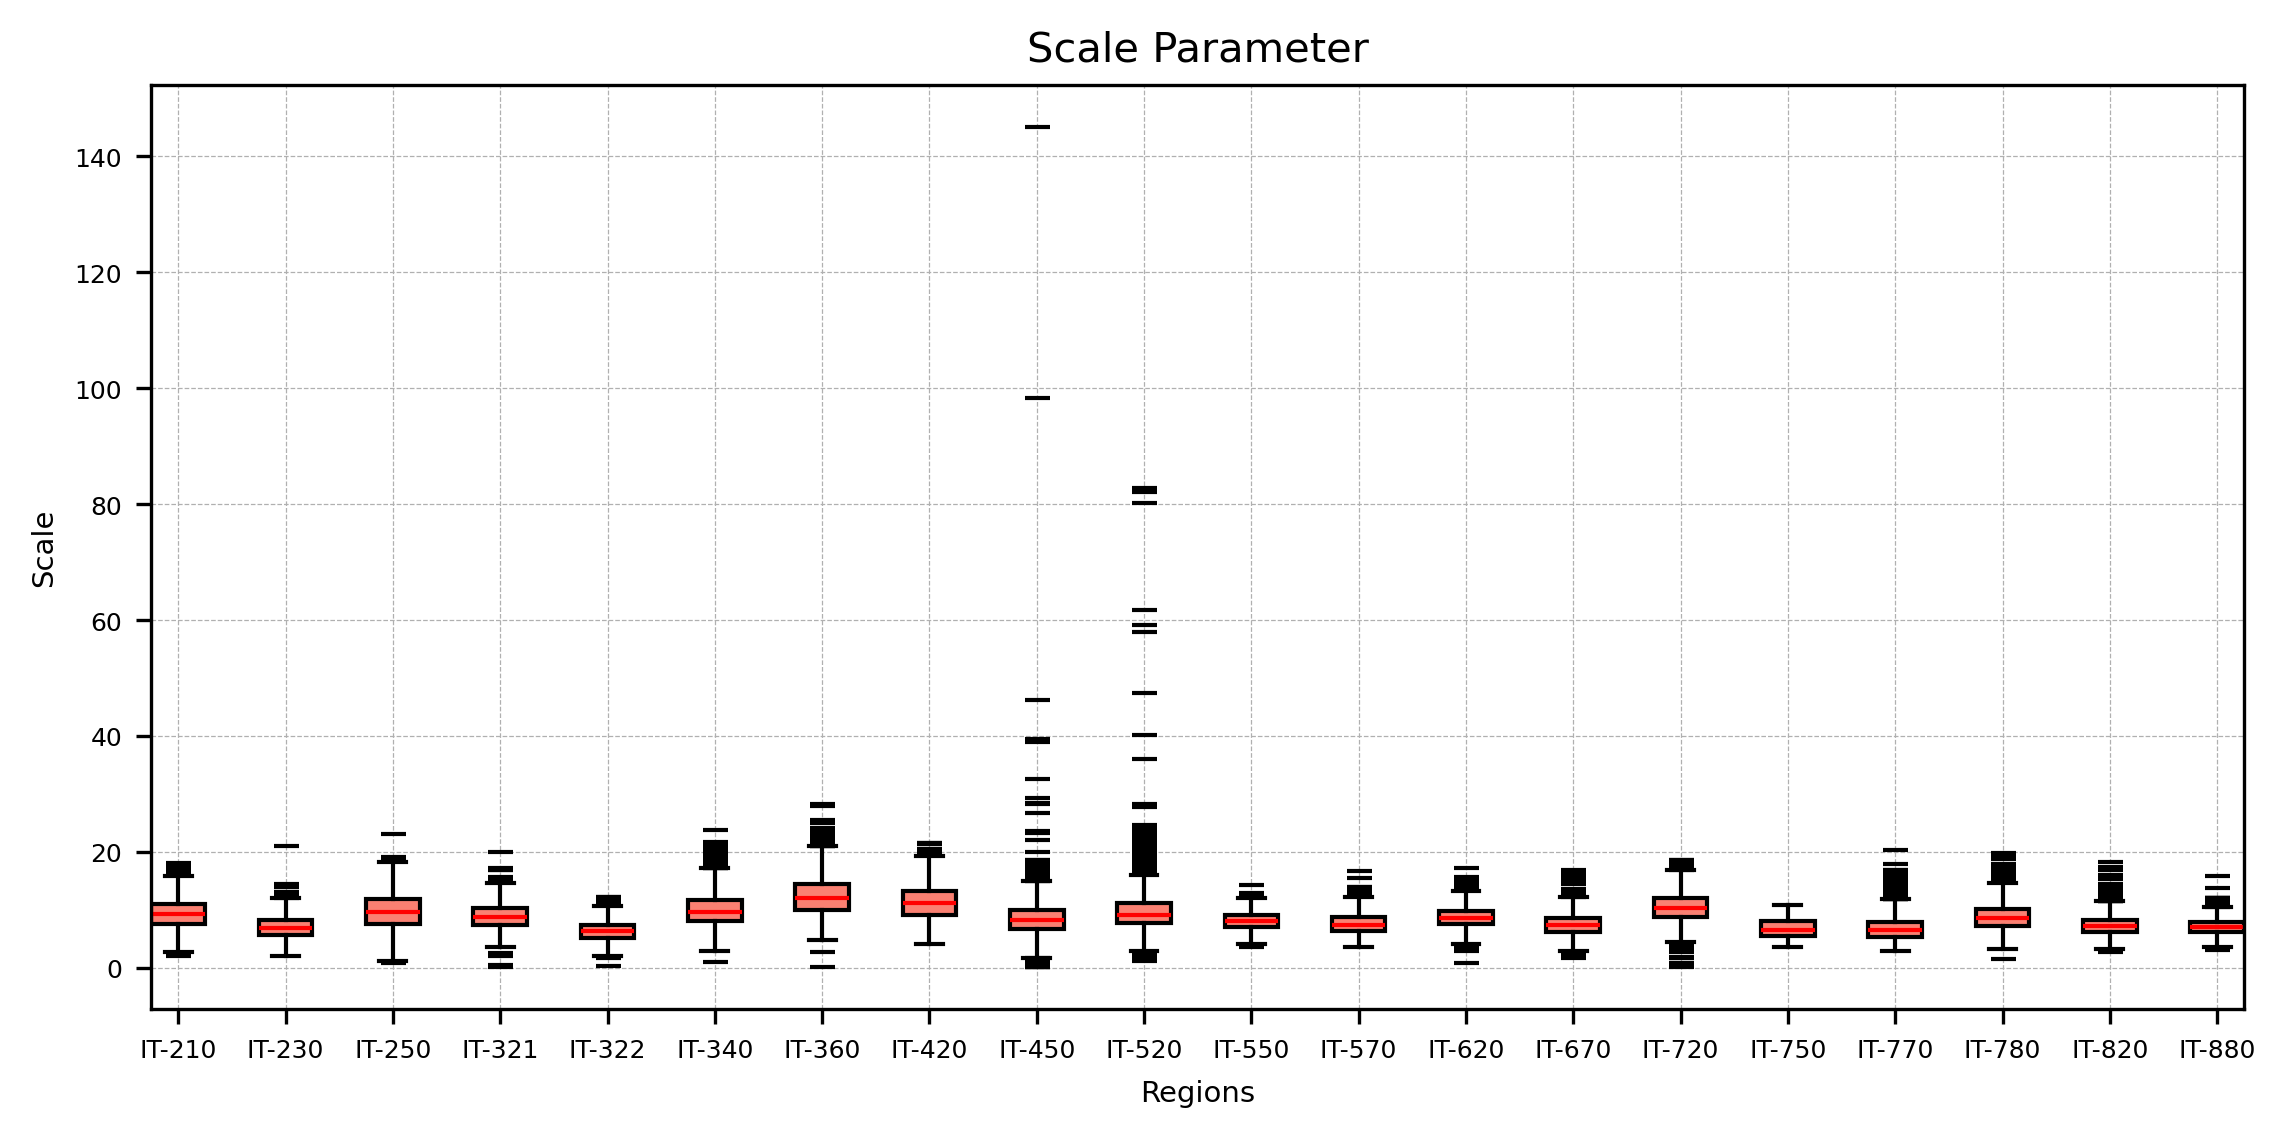

In [16]:
fig = plt.figure(figsize=(9,4),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])

SAT_boxprops = dict(facecolor='salmon')
DOWN_boxprops = dict(facecolor='royalblue')

meanprops=dict(linestyle='-',color="g",linewidth=1)
flierprops = dict(marker='_',markeredgecolor='k',linewidth=1.5)
medianprops = dict(linestyle='-', linewidth=1, color='r')

SAT_boxes = []
DOWN_boxes = []
medians = []
fliers = []
for pos in range(len(regions_ISO)):#len(regions_ISO)
    pre = diccionario_OBS_WC[regions_ISO[pos]].values
    pre_tmp = pre[~np.isnan(pre)]

    SAT_box = ax1.boxplot(pre_tmp,positions=[2*pos],
    widths=1,boxprops=SAT_boxprops,
    showmeans=False,meanline=True,meanprops=meanprops,
    medianprops=medianprops,
    showfliers=True,flierprops=flierprops,
    patch_artist=True,notch=False)

# ax1.set_xlim(-1,39)

ax1.set_xticks(np.arange(0,40,2))
ax1.set_xticklabels(regions_ISO)

ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.grid(linewidth=0.3, linestyle='--')

ax1.set_title('Scale Parameter', fontsize=10, loc='center')
ax1.set_ylabel('Scale', fontsize=7)
ax1.set_xlabel('Regions', fontsize=7)

Text(0.5, 0, 'Regions')

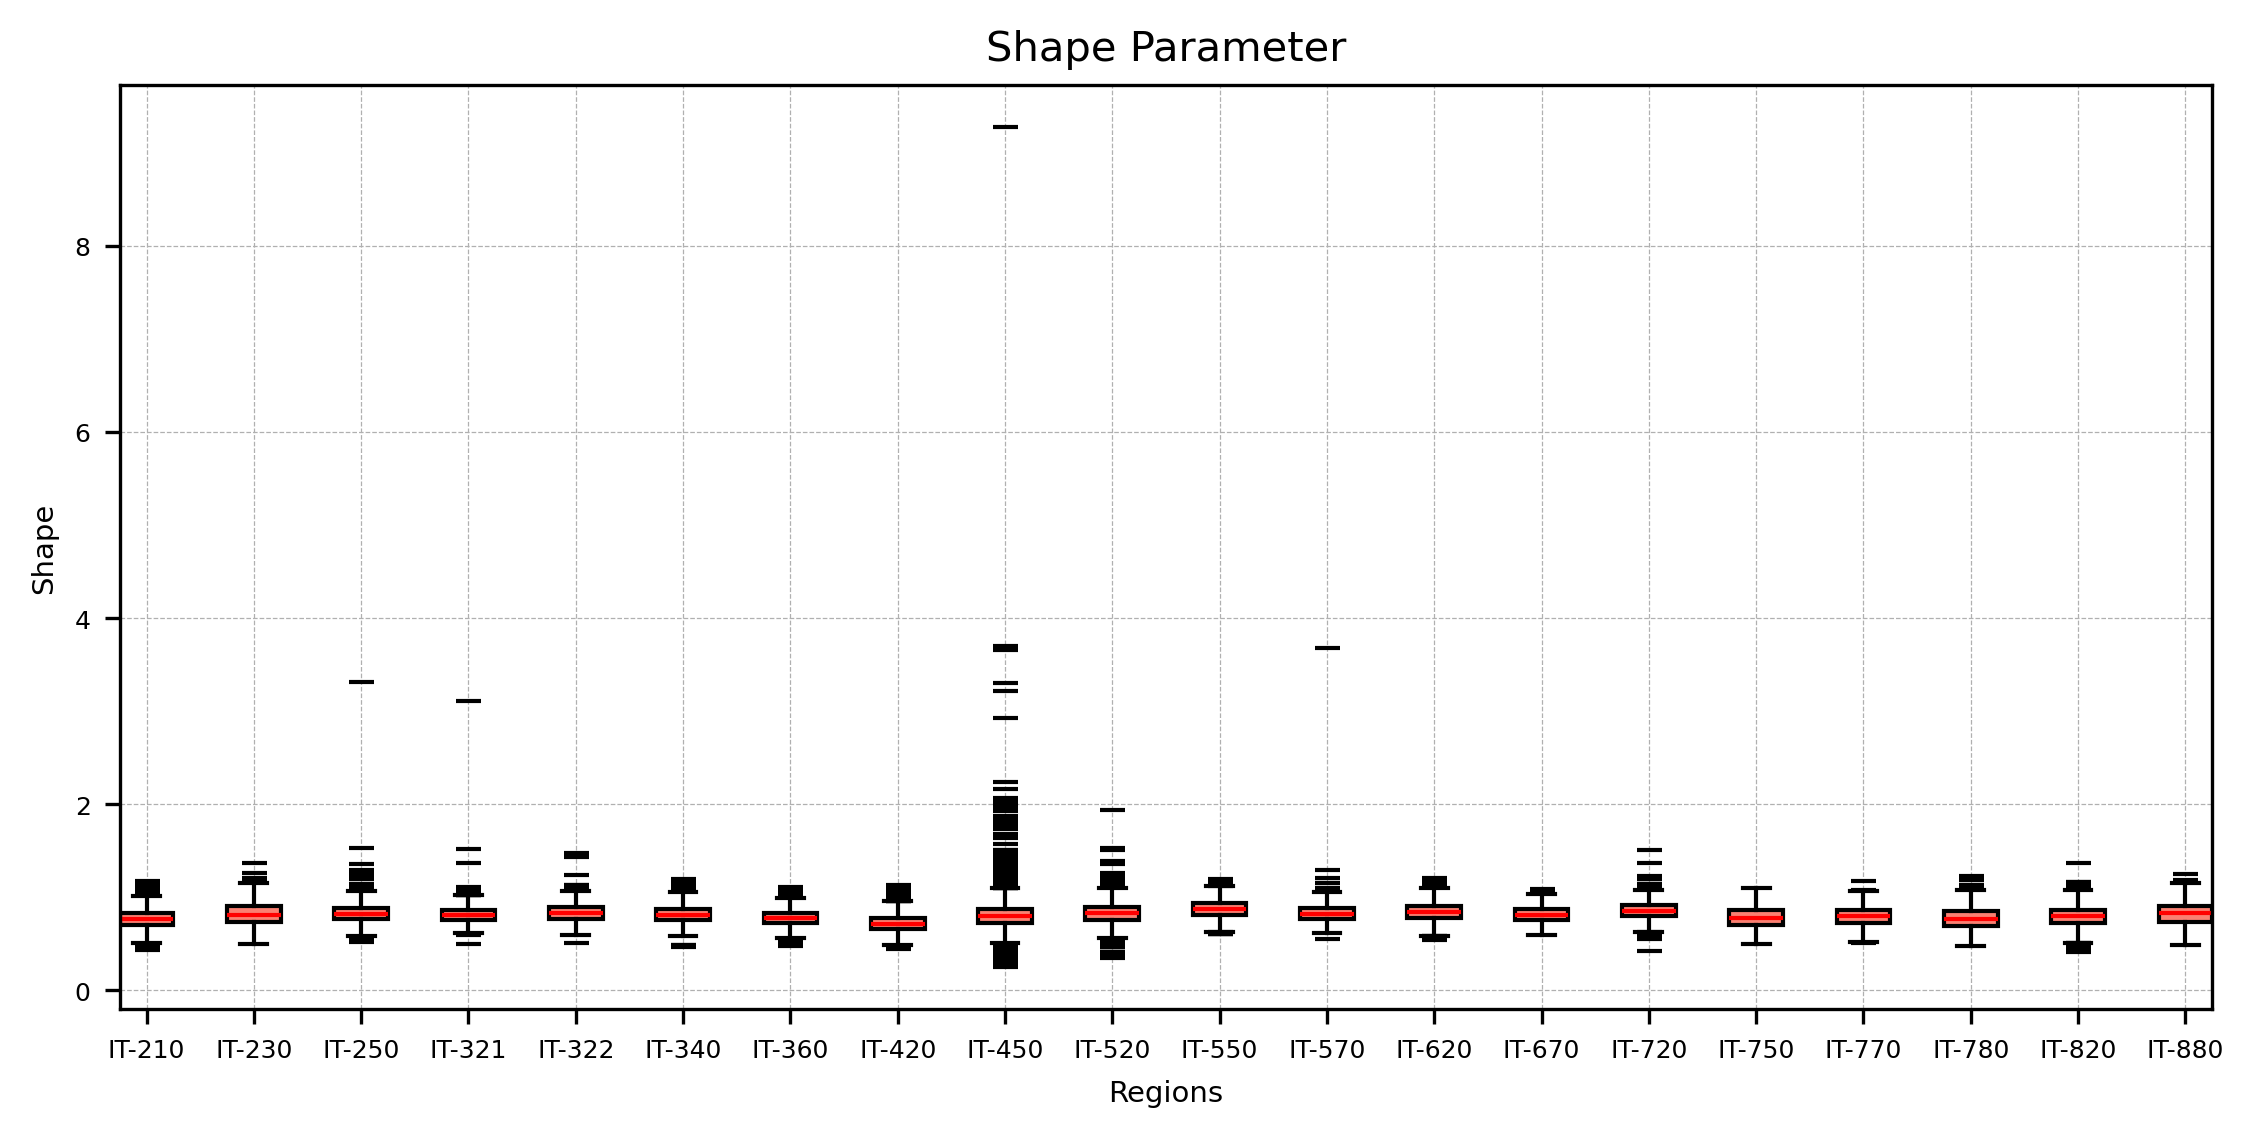

In [17]:
fig = plt.figure(figsize=(9,4),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])

SAT_boxprops = dict(facecolor='salmon')
DOWN_boxprops = dict(facecolor='royalblue')

meanprops=dict(linestyle='-',color="g",linewidth=1)
flierprops = dict(marker='_',markeredgecolor='k',linewidth=1.5)
medianprops = dict(linestyle='-', linewidth=1, color='r')

SAT_boxes = []
DOWN_boxes = []
medians = []
fliers = []
for pos in range(len(regions_ISO)):#len(regions_ISO)
    pre = diccionario_OBS_WW[regions_ISO[pos]].values
    pre_tmp = pre[~np.isnan(pre)]

    SAT_box = ax1.boxplot(pre_tmp,positions=[2*pos],
    widths=1,boxprops=SAT_boxprops,
    showmeans=False,meanline=True,meanprops=meanprops,
    medianprops=medianprops,
    showfliers=True,flierprops=flierprops,
    patch_artist=True,notch=False)

# ax1.set_xlim(-1,39)

ax1.set_xticks(np.arange(0,40,2))
ax1.set_xticklabels(regions_ISO)

ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.grid(linewidth=0.3, linestyle='--')

ax1.set_title('Shape Parameter', fontsize=10, loc='center')
ax1.set_ylabel('Shape', fontsize=7)
ax1.set_xlabel('Regions', fontsize=7)

In [18]:
dir_out = os.path.join(obs_base, 'QC', 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'OBS_Weibull_N.csv')
print(f'Export as: {dir_out}')
diccionario_OBS_WN.to_csv(dir_out, header=True, index=False)

dir_out = os.path.join(obs_base, 'QC', 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'OBS_Weibull_C.csv')
print(f'Export as: {dir_out}')
diccionario_OBS_WC.to_csv(dir_out, header=True, index=False)

dir_out = os.path.join(obs_base, 'QC', 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'OBS_Weibull_W.csv')
print(f'Export as: {dir_out}')
diccionario_OBS_WW.to_csv(dir_out, header=True, index=False)

Export as: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/QC/DATA_1dy/RE_ENSEMBLE_SAT/OBS_Weibull_N.csv
Export as: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/QC/DATA_1dy/RE_ENSEMBLE_SAT/OBS_Weibull_C.csv
Export as: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/QC/DATA_1dy/RE_ENSEMBLE_SAT/OBS_Weibull_W.csv


In [19]:
diccionario_SAT_WN = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_SAT_WN.items()]))
diccionario_SAT_WC = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_SAT_WC.items()]))
diccionario_SAT_WW = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_SAT_WW.items()]))

In [20]:
dir_out = os.path.join(obs_base, 'QC', 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'{font}_Weibull_N.csv')
print(f'Export as: {dir_out}')
diccionario_SAT_WN.to_csv(dir_out, header=True, index=False)

dir_out = os.path.join(obs_base, 'QC', 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'{font}_Weibull_C.csv')
print(f'Export as: {dir_out}')
diccionario_SAT_WC.to_csv(dir_out, header=True, index=False)

dir_out = os.path.join(obs_base, 'QC', 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'{font}_Weibull_W.csv')
print(f'Export as: {dir_out}')
diccionario_SAT_WW.to_csv(dir_out, header=True, index=False)

Export as: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/QC/DATA_1dy/RE_ENSEMBLE_SAT/DOWN_Weibull_N.csv
Export as: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/QC/DATA_1dy/RE_ENSEMBLE_SAT/DOWN_Weibull_C.csv
Export as: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/QC/DATA_1dy/RE_ENSEMBLE_SAT/DOWN_Weibull_W.csv


## Export Relative Error and Position

In [21]:
diccionario_RE = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_RE.items()]))
diccionario_LAT = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_LAT.items()]))
diccionario_LON = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_LON.items()]))

In [22]:
dir_out = os.path.join(obs_base, 'QC', 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'{font}_relative_error.csv')
print(f'Export as: {dir_out}')
diccionario_RE.to_csv(dir_out, header=True, index=False)

dir_out = os.path.join(obs_base, 'QC', 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'{font}_relative_error_lat.csv')
print(f'Export as: {dir_out}')
diccionario_LAT.to_csv(dir_out, header=True, index=False)

dir_out = os.path.join(obs_base, 'QC', 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'{font}_relative_error_lon.csv')
print(f'Export as: {dir_out}')
diccionario_LON.to_csv(dir_out, header=True, index=False)

Export as: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/QC/DATA_1dy/RE_ENSEMBLE_SAT/DOWN_relative_error.csv
Export as: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/QC/DATA_1dy/RE_ENSEMBLE_SAT/DOWN_relative_error_lat.csv
Export as: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/QC/DATA_1dy/RE_ENSEMBLE_SAT/DOWN_relative_error_lon.csv
